## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [3]:
# your code here
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel,RationalQuadratic,Exponentiation,ExpSineSquared

In [4]:
k1 = 1.0* RBF(length_scale=(1,1))
#k2 = WhiteKernel(noise_level=1., noise_level_bounds=(1e-3, 1e-3))
k2 = 1.**2 * RBF(length_scale=50) + WhiteKernel(noise_level=1,
                  noise_level_bounds=(1e-10, 1e10))
kernel = k1 + k2

In [5]:
gp = GaussianProcessRegressor(kernel=kernel,random_state=1)
X = np.asarray(Data1.loc[:,"Longitude":"Latitude"]).reshape(-1,2)
# Fit to data using Maximum Likelihood Estimation of the parameters
Y = np.asarray(Data1.loc[:,"AvgDailyTrafficCount"]).reshape(-1,1)
Y1 = np.log(Y) - np.log(Y).mean()
gp.fit(X,Y1)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=[1, 1]) + 1**2 * RBF(length_scale=50) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=1)

In [6]:
print gp.kernel_

0.647**2 * RBF(length_scale=[0.0323, 0.0393]) + 0.179**2 * RBF(length_scale=50.3) + WhiteKernel(noise_level=0.568)


In [7]:
print gp.log_marginal_likelihood_value_

-1363.8436485322968


In [8]:
y_pred, sigma = gp.predict(np.asarray(Data1.loc[:,"Longitude":"Latitude"]).reshape(-1,2), return_std=True)

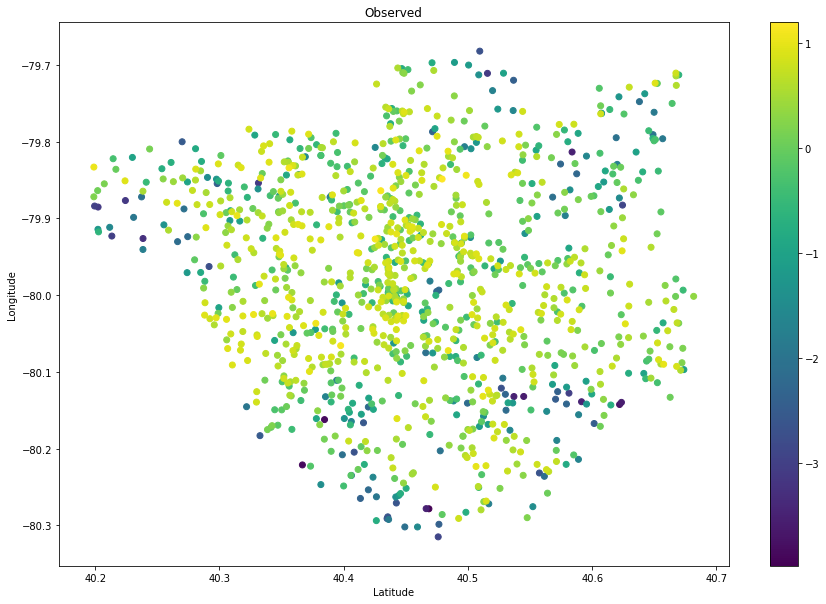

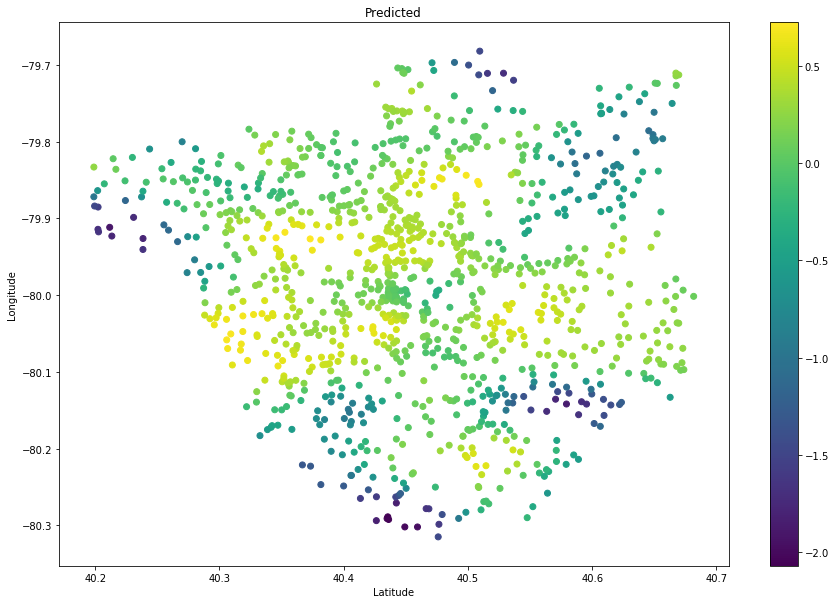

In [9]:
fig = plt.figure(figsize=(15,10))
plt.scatter(Data1.loc[:,"Latitude"],Data1.loc[:,"Longitude"],c=Y1,cmap='viridis')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Observed")
plt.colorbar()
plt.show()
fig = plt.figure(figsize=(15,10))
plt.scatter(Data1.loc[:,"Latitude"],Data1.loc[:,"Longitude"],c=y_pred,cmap='viridis')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Predicted")
plt.colorbar()
plt.show()

In [10]:
def returnCount():
    count = 0
    for i in range(0,len(y_pred)):
        if (float(Y1[i]) > float(y_pred[i]) + 2*float(sigma[i])) | (float(Y1[i]) < float(y_pred[i]) - 2*float(sigma[i])):
            count= count +1 
    return count

In [11]:
count = returnCount()

In [12]:
print("Percentage is: {}".format(count*100/len(y_pred)))

Percentage is: 4


In [13]:
normal = []
higher = []
lower = []
for i in range(0,len(y_pred)):
    if (float(Y1[i]) > float(y_pred[i]) + 2*float(sigma[i])):
        higher.append(i)
    elif (float(Y1[i]) < float(y_pred[i]) - 2*float(sigma[i])):
        lower.append(i)
    else :
        normal.append(i)

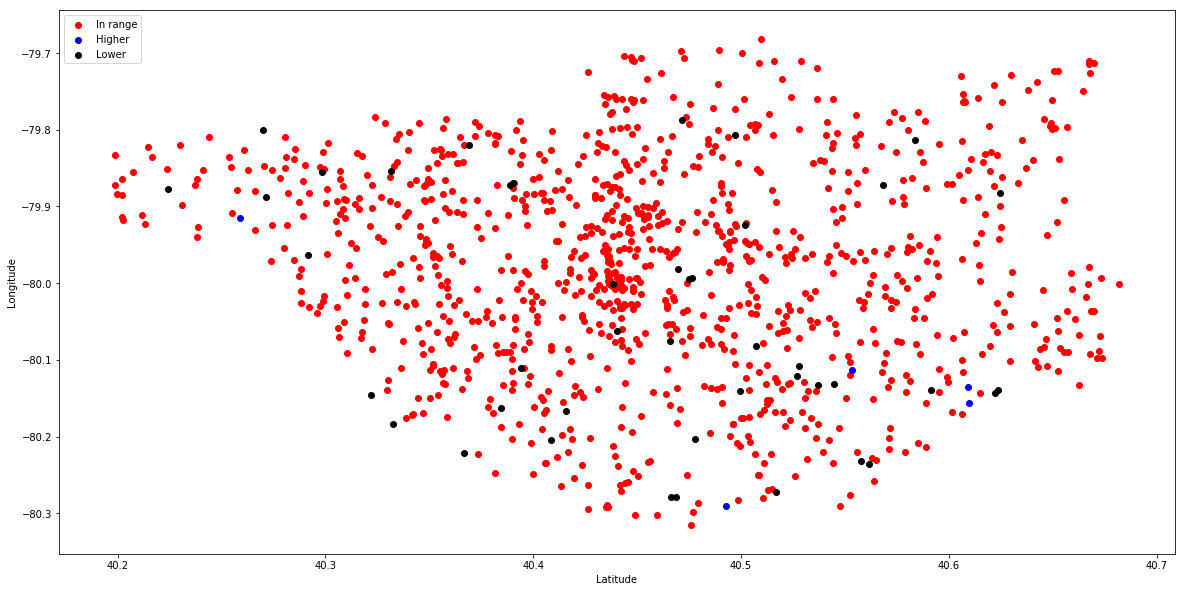

In [17]:
fig = plt.figure(figsize=(20,10))
plt.scatter(Data1.loc[normal,"Latitude"],Data1.loc[normal,"Longitude"],c='r',label="In range")
plt.scatter(Data1.loc[higher,"Latitude"],Data1.loc[higher,"Longitude"],c='b',label="Higher")
plt.scatter(Data1.loc[lower,"Latitude"],Data1.loc[lower,"Longitude"],c='k',label = "Lower")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly - Anomaly as the distance to Cluster A center is small but SD is less hence still it is an anomaly. 


(35, 2)		Anomaly / Not Anomaly - Not an Anomaly.Near center of a large cluster and the cluster has a large SD.


(15, 19)	Anomaly / Not Anomaly - Anomaly. It is closest to cluster center of cluster C. This cluster is very small compared to other clusters.


(10, 11)	Anomaly / Not Anomaly - Not an Anomaly. It is closest to cluster center of  cluster D and the cluster has a big SD. 


#### Your solution here

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [18]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [19]:
# your code here
Data2.shape

(3141, 31)

In [20]:
for column in Data2.columns[1:]:
    Data2.loc[:,column] = pd.to_numeric(Data2.loc[:,column],errors='coerce')

In [21]:
Data2.dropna(inplace=True,how='any')

In [22]:
Data2.shape

(2486, 31)

In [23]:
Data2.describe()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,...,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,17.203942,3.865809,3.753097,8.222446,18.569992,31.022928,7.093242,27.162108,63.002011,16.604988,...,23.844730,4.545133,33.345937,12.731175,267.538616,74.454545,11.720072,14.958568,80.197908,30.881738
std,4.856641,0.715394,0.581101,1.971016,3.646631,4.524278,1.069392,5.554257,22.020285,3.420385,...,8.692791,0.695486,9.383930,4.981697,198.532609,21.554035,1.535203,4.277249,5.945515,11.935865
min,7.000000,2.200000,2.100000,3.000000,7.000000,11.000000,0.500000,9.000000,0.000000,9.000000,...,3.000000,2.700000,1.000000,1.000000,0.000000,25.000000,7.200000,5.000000,6.000000,3.000000
25%,13.000000,3.400000,3.300000,7.000000,16.000000,29.000000,6.500000,24.000000,48.000000,14.000000,...,17.250000,4.100000,27.000000,9.300000,128.000000,60.000000,10.600000,12.000000,78.000000,22.000000
50%,16.000000,3.800000,3.800000,8.000000,18.000000,31.000000,7.200000,27.000000,65.000000,17.000000,...,23.000000,4.400000,33.000000,12.100000,216.000000,72.000000,12.000000,14.000000,81.000000,30.000000
75%,20.000000,4.400000,4.100000,9.000000,21.000000,34.000000,7.800000,31.000000,80.000000,19.000000,...,29.000000,4.900000,38.000000,15.500000,356.750000,87.000000,13.000000,17.000000,84.000000,39.000000
max,42.000000,6.500000,5.600000,19.000000,41.000000,46.000000,10.000000,42.000000,100.000000,27.000000,...,54.000000,8.700000,76.000000,41.000000,1885.000000,200.000000,14.900000,44.000000,95.000000,72.000000


In [158]:
# Part 1

In [24]:
df=Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

In [25]:
df.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,19.0,31,254.0,4.3,18.0,12.9
1,19.0,27,221.0,4.5,20.0,13.1
2,21.0,41,147.0,5.3,38.0,12.6
3,21.0,40,236.0,4.3,27.0,12.9
4,19.0,32,219.0,4.1,24.0,12.7


In [26]:
for column in df.columns:
    df.loc[:,column] = pd.cut(df.loc[:,column],5,labels = [0,1,2,3,4])

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
df.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
0,1,2,0,1,1,3
1,1,2,0,1,1,3
2,2,4,0,2,3,3
3,2,4,0,1,2,3
4,1,2,0,1,2,3


In [28]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
hc = HillClimbSearch(df, scoring_method=BicScore(df))
best_model = hc.estimate()
print(best_model.edges())

[("'\\% Smokers'", "'Average Daily PM2.5'"), ("'\\% Smokers'", "'\\% Obese'"), ("'\\% Children in Poverty'", "'80/20 Income Ratio'"), ("'\\% Children in Poverty'", "'\\% Smokers'"), ("'Violent Crime Rate'", "'\\% Children in Poverty'")]


In [40]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

model = BayesianModel(best_model.edges())
model.fit(df, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of '80/20 Income Ratio':
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '\% Children in Poverty' | '\% Children in Poverty'(0) | '\% Children in Poverty'(1) | '\% Children in Poverty'(2) | '\% Children in Poverty'(3) | '\% Children in Poverty'(4) |
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '80/20 Income Ratio'(0)  | 0.4875444839857651          | 0.24113475177304963         | 0.06117908787541713         | 0.026515151515151516        | 0.0                         |
+--------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| '80/20 Income Ratio'(1)  | 0.4875444839857651          | 0.705167173252279

In [41]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print thevariable,theparents,theprob
        loglike += np.log(theprob)
    return loglike

In [42]:
exmp=df.iloc[:,:].apply(lambda x: LL(x,model),axis=1)
print exmp.sort_values().head(5)

1856   -16.608495
221    -14.827149
2027   -14.686742
1227   -14.457849
317    -13.671439
dtype: float64


In [45]:
new = pd.DataFrame({"County":Data2.County,"Log-liklihood":exmp})

In [46]:
new.sort_values(by="Log-liklihood").head(5)

,County,Log-liklihood
1856,"New York, New York",-16.608495
221,"San Francisco, California",-14.827149
2027,"Roulette, North Dakota",-14.686742
1227,"Suffolk, Massachusetts",-14.457849
317,"District of Columbia, District of Columbia",-13.671439


In [169]:
#Part 2

In [47]:
Data2.describe()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,...,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,17.203942,3.865809,3.753097,8.222446,18.569992,31.022928,7.093242,27.162108,63.002011,16.604988,...,23.844730,4.545133,33.345937,12.731175,267.538616,74.454545,11.720072,14.958568,80.197908,30.881738
std,4.856641,0.715394,0.581101,1.971016,3.646631,4.524278,1.069392,5.554257,22.020285,3.420385,...,8.692791,0.695486,9.383930,4.981697,198.532609,21.554035,1.535203,4.277249,5.945515,11.935865
min,7.000000,2.200000,2.100000,3.000000,7.000000,11.000000,0.500000,9.000000,0.000000,9.000000,...,3.000000,2.700000,1.000000,1.000000,0.000000,25.000000,7.200000,5.000000,6.000000,3.000000
25%,13.000000,3.400000,3.300000,7.000000,16.000000,29.000000,6.500000,24.000000,48.000000,14.000000,...,17.250000,4.100000,27.000000,9.300000,128.000000,60.000000,10.600000,12.000000,78.000000,22.000000
50%,16.000000,3.800000,3.800000,8.000000,18.000000,31.000000,7.200000,27.000000,65.000000,17.000000,...,23.000000,4.400000,33.000000,12.100000,216.000000,72.000000,12.000000,14.000000,81.000000,30.000000
75%,20.000000,4.400000,4.100000,9.000000,21.000000,34.000000,7.800000,31.000000,80.000000,19.000000,...,29.000000,4.900000,38.000000,15.500000,356.750000,87.000000,13.000000,17.000000,84.000000,39.000000
max,42.000000,6.500000,5.600000,19.000000,41.000000,46.000000,10.000000,42.000000,100.000000,27.000000,...,54.000000,8.700000,76.000000,41.000000,1885.000000,200.000000,14.900000,44.000000,95.000000,72.000000


In [48]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(Data2.iloc[:,1:])

# distance to each cluster center
res=pd.DataFrame(KM.transform(Data2.iloc[:,1:]))

In [49]:
res=pd.DataFrame(KM.transform(Data2.iloc[:,1:]))
res.index = Data2.index
res.head()

,0,1,2
0,215.546368,554.609617,101.895485
1,108.370262,655.932344,186.335226
2,410.503731,530.643663,282.291939
3,168.209200,602.378878,141.457457
4,105.075152,777.335076,315.009861


In [50]:
scor=KM.fit_predict(Data2.iloc[:,1:])
score = pd.DataFrame(scor,columns=['cluster'])
score.index = Data2.index
score.head()

,cluster
0,2
1,0
2,2
3,2
4,0


In [51]:
res=pd.concat((res,score),axis=1)
res.head()

,0,1,2,cluster
0,215.546368,554.609617,101.895485,2
1,108.370262,655.932344,186.335226,0
2,410.503731,530.643663,282.291939,2
3,168.209200,602.378878,141.457457,2
4,105.075152,777.335076,315.009861,0


In [52]:
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)
res['County'] = Data2.loc[:,"County"]
# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score,County
2415,2443.716031,1970.018443,2251.260167,1,1970.018443,"Shannon, South Dakota"
1595,2036.147297,1332.735955,1759.249198,1,1332.735955,"St. Louis City, Missouri"
126,1917.732820,1208.900834,1639.063836,1,1208.900834,"Crittenden, Arkansas"
2939,1644.876605,1017.910163,1394.632068,1,1017.910163,"Petersburg City, Virginia"
1214,1651.954082,918.374430,1366.737248,1,918.374430,"Baltimore City, Maryland"


In [53]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(Data2.iloc[:,1:])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [54]:
res = GM.score_samples(Data2.iloc[:,1:])
#pd.DataFrame().sort_values(0)[:5]
result = pd.DataFrame(res)
result.index = Data2.index
result["County"] = Data2.loc[:,"County"]
result.head()

,0,County
0,-77.014952,"Autauga, Alabama"
1,-73.246282,"Baldwin, Alabama"
2,-83.545188,"Barbour, Alabama"
3,-83.077074,"Bibb, Alabama"
4,-81.157514,"Blount, Alabama"


In [55]:
result.sort_values(0)[:5]

,0,County
2415,-197.420106,"Shannon, South Dakota"
94,-133.042814,"Apache, Arizona"
1856,-131.452092,"New York, New York"
2765,-129.450559,"Willacy, Texas"
2027,-126.696033,"Roulette, North Dakota"


In [56]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20)
clf.fit(Data2.iloc[:,1:])
res = clf._decision_function(Data2.iloc[:,1:])
result = pd.DataFrame(res,columns=['score'])
result.index = Data2.index
res = pd.concat((pd.DataFrame(Data2['County']),result),axis=1)

In [57]:
res.columns = ["County","score"]
print(res.sort_values("score",ascending=True)[:5])

                         County     score
2415      Shannon, South Dakota -4.547643
1595   St. Louis City, Missouri -2.519539
126        Crittenden, Arkansas -2.228699
3024    Nicholas, West Virginia -2.145999
2939  Petersburg City, Virginia -2.055315


The top 5 most anomalous by Bayesian are:

1)1856	New York, New York	

2)221	San Francisco, California

3)2027	Roulette, North Dakota	

4)1227	Suffolk, Massachusetts	

5)317	District of Columbia, District of Columbia	


The top 5 most anomalous by K-Means are:

1.2415	Shannon, South Dakota

2.1595	St. Louis City, Missouri

3.126		Crittenden, Arkansas

4.2939	Petersburg City, Virginia

5.1214	Baltimore City, Maryland

The top 5 most anomalus by GM are:

1.2415	Shannon, South Dakota

2.94	    Apache, Arizona

3.1856	New York, New York

4.765	Willacy, Texas

5.2027	Roulette, North Dakota

The top 5 most anomalous by LOF are :

1.2415      Shannon, South Dakota 

2.1595   St. Louis City, Missouri 

3.126        Crittenden, Arkansas 

4.3024    Nicholas, West Virginia 

5.2939  Petersburg City, Virginia 

1) New York was found anomalous by Bayesian and GM but not by others.
2) Roulette, North Dakota was found anomalous by Bayesian and GM but not by others.
3) Petersburg City, Virginia was found anomalous by k-means and LOF but not by others. 
4) Shannon, South Dakota was found most anomalous by K-Means, GM and LOF but not by others.
5) St. Louis City, Missouri was found anomalous by K-Means and LOF but not by others.
6) Crittenden, Arkansas was found anomalous by LOF and K-Means.

In [33]:
pd.options.display.max_columns = 1000

In [34]:
first = Data2[Data2['County'] == 'New York, New York']
first

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate','Teen Birth Rate','\% Uninsured','Preventable Hosp. Rate','\% Dibetics receiving HbA1c','\% Mammography','Graduation Rate','\% Some College','\% Unemployed','\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
1856,"New York, New York",14.0,3.5,3.5,9.0,13.0,15,7.8,18,98.0,21.0,10.0,706.0,21.0,11.0,42.0,81.0,61.0,66.0,83.0,6.1,24.0,8.7,41.0,13.0,620.0,32.0,10.8,25,6.0,63.0


In [35]:
first[ ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
1856,13.0,15,620.0,8.7,24.0,10.8


New York was marked anomalous because of very high 80/20 Income ratio and low children in poverty.

In [36]:
second = Data2[Data2['County'] == 'Roulette, North Dakota']
second

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate','Teen Birth Rate','\% Uninsured','Preventable Hosp. Rate','\% Dibetics receiving HbA1c','\% Mammography','Graduation Rate','\% Some College','\% Unemployed','\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
2027,"Roulette, North Dakota",29.0,5.1,4.5,10.0,38.0,41,6.9,34,21.0,20.0,59.0,1203.0,96.0,21.0,117.0,40.0,45.0,68.0,62.4,11.8,41.0,7.7,59.0,6.2,29.0,104.0,9.6,21,84.0,14.0


Roulette, North Dakota was marked anomalous because of difference in percentage between %Drive Alone and %Lon Commute-Drives Alone

In [38]:
third = Data2[Data2['County'] == 'Shannon, South Dakota']
third

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking','\% Alcohol-Impaired Driving Deaths','Chlamydia Rate','Teen Birth Rate','\% Uninsured','Preventable Hosp. Rate','\% Dibetics receiving HbA1c','\% Mammography','Graduation Rate','\% Some College','\% Unemployed','\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
2415,"Shannon, South Dakota",33.0,5.9,4.7,7.0,41.0,45,1.6,24,2.0,16.0,68.0,2653.0,110.0,17.0,161.0,19.0,26.0,3.0,51.8,13.2,54.0,6.5,68.0,2.8,0.0,200.0,11.8,44,64.0,22.0


Shannon, South Dakota was marked anomalous because "Graduation Rate' is 3 and 'Violent Crime Rate' is 0.